In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
from dotenv import load_dotenv
import torch.nn.functional as F
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from transformers.models.llama import LlamaForCausalLM
from transformers import BitsAndBytesConfig
import html
import json
import random
from model_wrapper import ModelWrapper, InterventionSettings, Intervention
from utils import format_conversation
from viz import visualize_token_nlls
from collections import defaultdict
from tqdm import tqdm

In [3]:
load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")

In [4]:
MODEL_LLAMA_3_CHAT = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_LLAMA_3_CHAT, token=HUGGINGFACE_TOKEN
)

In [6]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [7]:
model = ModelWrapper()

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


In [8]:
model.reset_hooks()

In [9]:
messages = [
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "Paris."},
    {"role": "user", "content": "What do people like to eat there?"},
    {"role": "assistant", "content": "People in Paris like to eat croissants and baguettes."},
    {"role": "user", "content": "That's interesting. What about the weather? What is it like in the summer?"},
]

In [10]:
messages_formatted = format_conversation(messages, tokenizer, add_generation_prompt=True)

In [11]:
print(messages_formatted)

<|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [12]:
tokens = tokenizer.encode(messages_formatted, return_tensors="pt")

In [13]:
print(tokenizer.decode(tokens[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [14]:
per_token_nlls = model.get_per_token_nlls(tokens)

In [15]:
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [16]:
role_nlls = model.get_role_nlls(tokens)

In [17]:
for item in role_nlls:
    token_str = tokenizer.decode(item['tokens']).replace('\n', '\\n')
    print(f"{tokenizer.decode(item['role'])} (NLL={item['nll']}): '{token_str}'")

user (NLL=33.5): '\n\nWhat is the capital of France?'
assistant (NLL=8.125): '\n\nParis.'
user (NLL=25.875): '\n\nWhat do people like to eat there?'
assistant (NLL=34.25): '\n\nPeople in Paris like to eat croissants and baguettes.'
user (NLL=50.5): '\n\nThat's interesting. What about the weather? What is it like in the summer?'
assistant (NLL=0.0): '\n\n'


In [18]:
generation = model.sample(tokens.to(model.device), max_n_tokens=500)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [19]:
print(tokenizer.decode(generation[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22-25°C (72-77°F) from June to August. However, it's not uncommon to experience occasional heatwaves, and the city can get quite crowded during the peak tourist season.<|eot_id|>


In [20]:
assistant_token_embedding = model.assistant_token_embedding
user_token_embedding = model.user_token_embedding

In [29]:
intervention = InterventionSettings(
    intervention=Intervention.EMBEDDING_COLOR,
    user_vector=user_token_embedding*0.5,
    assistant_vector=assistant_token_embedding*0.5,
)

In [30]:
model.set_intervention(intervention)

In [31]:
model.hooks

In [32]:
generation = model.sample(tokens.to(model.device), max_n_tokens=250)
print(tokenizer.decode(generation[0]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22°C to 25°C (72°F to 77°F) from June to August. However, it's not uncommon to experience occasional heatwaves, especially in July and August.

It's also a good idea to be prepared for occasional rain showers, as Paris can experience sudden downpours during the summer months. But overall, the summer weather in Paris is often described as 

In [33]:
per_token_nlls = model.get_per_token_nlls(tokens)
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [72]:
def get_msj_nlls(model: ModelWrapper, dataset: list[dict]|str):
    if isinstance(dataset, str):
        with open(dataset) as f:
            dataset = json.load(f)
    result = defaultdict(list)
    for row in tqdm(dataset):
        tokens = torch.tensor(row["tokens"]).to(model.device)
        nlls = model.get_role_nlls(tokens)
        result[row['n_shots']].append(nlls)
    return result

In [54]:
model.reset_hooks()
msj_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json")
msj_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_recovery.json")
msj_mean_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json")
msj_mean_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json")

In [63]:
def plot_nlls(results, legend, figsize=(7, 3), title = None):
    fig, ax = plt.subplots(figsize=figsize)
    for r, l in zip(results, legend):
        data = sorted([
            (k, sum([r[-1]['nll'] for r in v])/len(v)) for k, v in r.items()
        ])
        shots, nlls = zip(*data)
        shots = np.array(shots)
        ax.plot(shots, nlls, 'o-', markersize=5, label=l)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('NLL of final assistant response')    
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

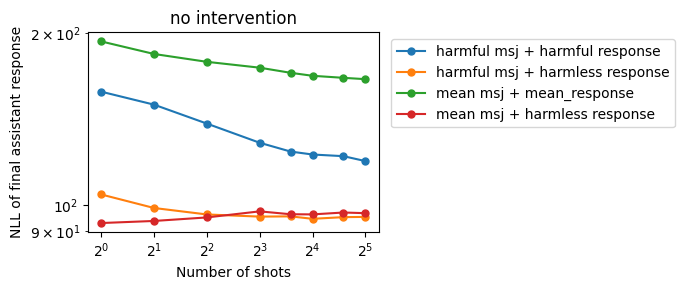

In [65]:
plot_nlls([msj_jailbreak_nlls, msj_recovery_nlls, msj_mean_jailbreak_nlls, msj_mean_recovery_nlls], ['harmful msj + harmful response', 'harmful msj + harmless response', 'mean msj + mean_response', 'mean msj + harmless response'], title="no intervention")

In [66]:
intervention = InterventionSettings(
    intervention=Intervention.EMBEDDING_COLOR,
    user_vector=user_token_embedding*0.5,
    assistant_vector=assistant_token_embedding*0.5,
)
model.set_intervention(intervention)
msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json")
msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json")

100%|██████████| 400/400 [03:06<00:00,  2.14it/s]


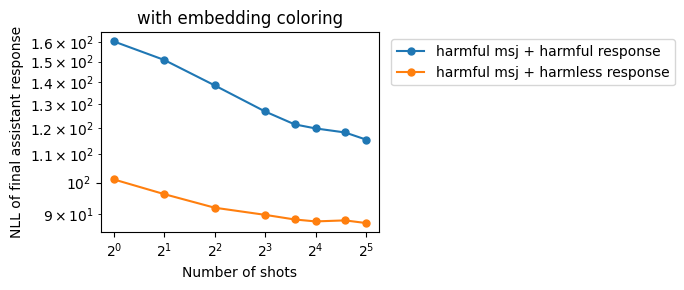

In [67]:
plot_nlls([msj_jailbreak_nlls_colored, msj_recovery_nlls_colored, msj_jailbreak_nlls, msj_recovery_nlls], ['(coloring) harmful msj + harmful response', '(coloring) harmful msj + harmless response', 'harmful msj + harmful response', 'harmful msj + harmless response'])